### mining 모듈이 Import 되지 않을 때 실행
---
```python
import sys
import os

os.chdir("<mining 디렉토리의 root directory 주소>") # root로 설정해야, mining, clustering 모두 접근가능
current_dir = os.path.abspath(os.getcwd()) 
if current_dir not in sys.path: sys.path.insert(0, current_dir)
```

### 1. One Step EDA
---

In [1]:
from mining import one_step_EDA_from_bigquery 
import warnings
warnings.filterwarnings('ignore')

eda = one_step_EDA_from_bigquery(
    path="key.json", 
    limit=None, 
    start_name='start', 
    end_name='end', 
    case_type=None
)

In [2]:
eda.Transition.Frequency.all_cnts

,Source,Target,Variable
0,start,SL,117
1,start,SI,333
2,start,CH,4
3,SL,SI,280
4,SL,SL,113
6,SL,CH,11
7,SI,SI,960
9,SI,SL,306
10,SI,CH,28
11,CH,SI,20


In [3]:
eda.Transition.Probability.visualizer(layered=True, grouped=False)

### 2. step by step (Daraframe → EDA)
---

In [4]:
from mining.utils import load_data_from_bigquery
from mining.preprocessing import define_at_bat_cases
from mining.preprocessing import add_node_and_preprocess
from mining.preprocessing import one_way_filter
from mining.probability import BasedTraces
from mining.exploratory import ProcessEDA

In [5]:
df = load_data_from_bigquery()
df[['game_date', 'batter', 'pitch_type','events']].head(10)

,game_date,batter,pitch_type,events
0,2019-10-01,665742,SI,single
1,2019-10-01,665742,SL,None
2,2019-10-01,665742,SI,None
3,2019-10-01,543685,SI,walk
4,2019-10-01,543685,SI,None
5,2019-10-01,543685,SI,None
6,2019-10-01,543685,SI,None
7,2019-10-01,543685,SI,None
8,2019-10-01,543685,SI,None
9,2019-10-01,475582,SI,single


In [6]:
df_grouped = define_at_bat_cases(df)
df_grouped.head(10)[['game_date', 'batter', 'pitch_type', 'events','processID', 'pitchOrder']]

,game_date,batter,pitch_type,events,processID,pitchOrder
0,2019-10-01,665742,SI,single,0,2
1,2019-10-01,665742,SL,None,0,1
2,2019-10-01,665742,SI,None,0,0
3,2019-10-01,543685,SI,walk,1,5
4,2019-10-01,543685,SI,None,1,4
5,2019-10-01,543685,SI,None,1,3
6,2019-10-01,543685,SI,None,1,2
7,2019-10-01,543685,SI,None,1,1
8,2019-10-01,543685,SI,None,1,0
9,2019-10-01,475582,SI,single,2,3


In [7]:
# 결측치 indexing (pitch_type)
missing_index = set(df_grouped[df_grouped['pitch_type'].isna()]['processID'])
valid_index = ~df_grouped['processID'].isin(missing_index)

# 결측치 제거
df_valid = df_grouped[valid_index]
df_valid.head(10)[['game_date', 'batter', 'pitch_type', 'events','processID', 'pitchOrder']]

,game_date,batter,pitch_type,events,processID,pitchOrder
0,2019-10-01,665742,SI,single,0,2
1,2019-10-01,665742,SL,None,0,1
2,2019-10-01,665742,SI,None,0,0
3,2019-10-01,543685,SI,walk,1,5
4,2019-10-01,543685,SI,None,1,4
5,2019-10-01,543685,SI,None,1,3
6,2019-10-01,543685,SI,None,1,2
7,2019-10-01,543685,SI,None,1,1
8,2019-10-01,543685,SI,None,1,0
9,2019-10-01,475582,SI,single,2,3


In [8]:
# 시작, 종료 노드 추가
df_added = add_node_and_preprocess(df_valid, start_name='start', end_name='end', case_type=None)
display(df_added.head(10)[['case:concept:name','time:timestamp', 'batter', 'pitch_type', 'events', 'pitchOrder']])

print('\n === 구종 테이블 ===')
display(df_added.pitch_type.value_counts().to_frame())

print('\n === Events 테이블 ===')
display(df_added.events.value_counts().to_frame())


,case:concept:name,time:timestamp,batter,pitch_type,events,pitchOrder
0,0,2019-09-30 23:59:59,665742,start,None,-1
1,0,2019-10-01 00:00:00,665742,SI,None,0
2,0,2019-10-01 00:00:01,665742,SL,None,1
3,0,2019-10-01 00:00:02,665742,SI,single,2
4,0,2019-10-01 00:00:03,665742,end,single,3
5,1,2019-09-30 23:59:59,543685,start,None,-1
6,1,2019-10-01 00:00:00,543685,SI,None,0
7,1,2019-10-01 00:00:01,543685,SI,None,1
8,1,2019-10-01 00:00:02,543685,SI,None,2
9,1,2019-10-01 00:00:03,543685,SI,None,3



 === 구종 테이블 ===


,count
pitch_type,
SI,3394
SL,1121
start,1081
end,1081
CH,129
FF,4



 === Events 테이블 ===


,count
events,
strikeout,744
field_out,593
single,180
walk,159
home_run,66
double,46
hit_by_pitch,31
force_out,24
grounded_into_double_play,13


In [9]:
# strikeout만 filtering
df_filtered = one_way_filter(df_added, colName = 'events', posCondition = ['strikeout'])
display(df_filtered.head(10)[['case:concept:name','time:timestamp', 'batter', 'pitch_type', 'events', 'pitchOrder']])

print('\n === 구종 테이블 ===')
display(df_filtered.pitch_type.value_counts().to_frame())

print('\n === Events 테이블 ===')
display(df_filtered.events.value_counts().to_frame())


,case:concept:name,time:timestamp,batter,pitch_type,events,pitchOrder
19,3,2019-10-01 00:00:03,607208,start,strikeout,-1
20,3,2019-10-01 00:00:00,607208,SL,None,0
21,3,2019-10-01 00:00:01,607208,SI,None,1
22,3,2019-10-01 00:00:02,607208,SI,None,2
23,3,2019-10-01 00:00:03,607208,SI,None,3
24,3,2019-10-01 00:00:04,607208,SI,strikeout,4
25,3,2019-10-01 00:00:01,607208,end,None,5
34,5,2019-09-30 23:59:59,645302,start,None,-1
35,5,2019-10-01 00:00:00,645302,SI,None,0
36,5,2019-10-01 00:00:01,645302,SL,None,1



 === 구종 테이블 ===


,count
pitch_type,
SI,1593
SL,543
start,454
end,454
CH,46



 === Events 테이블 ===


,count
events,
strikeout,744


In [10]:
# Event Log 데이터를 Probability로 계산
calc_eventlog = BasedTraces(df_filtered) 
final_result = calc_eventlog()

# Process EDA
eda = ProcessEDA(final_result)

In [11]:
eda.Transition.Frequency.all_cnts

,Source,Target,Variable
0,start,SL,117
1,start,SI,333
2,start,CH,4
3,SL,SI,280
4,SL,SL,113
6,SL,CH,11
7,SI,SI,960
9,SI,SL,306
10,SI,CH,28
11,CH,SI,20


In [12]:
eda.Transition.Probability.visualizer(layered=True, grouped=False)

### 3. step by step (Daraframe → Clustering)
---

In [13]:
from clustering.distance import ClusteredTraces
from clustering.visualizer import MDS, Dendrogram

In [14]:
# Traces 별 Levinsutain
clusted = ClusteredTraces(df_filtered)
final_results = clusted(n_clusters = 3)

In [15]:
display(final_results['traces'][:5])
display(final_results['sequences'][:5])
display(final_results['labels'][:5])
display(final_results['clusters'])

[{'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:03+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-30 23:59:59+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:06+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-28 00:00:02+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-09-28 00:00:02+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-27 23:59:59+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-09-28 00:00:03+0000', tz='UTC')}]},
 {'attributes': {}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-09-24 00:

[['start', 'SL', 'SI', 'SI', 'SI', 'SI', 'end'],
 ['start', 'SI', 'SL', 'SI', 'SI', 'SI', 'SI', 'end'],
 ['start', 'SI', 'SL', 'SL', 'SL', 'SI', 'end'],
 ['start', 'SI', 'SI', 'SI', 'end'],
 ['start', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SL', 'end']]

['T00', 'T01', 'T02', 'T03', 'T04']

array([1, 1, 1, 2, 0, 2, 1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 1,
       1, 2, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 0, 1, 1,
       2, 2, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1,
       0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 2, 0, 1, 1, 0, 1, 1,
       0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0])

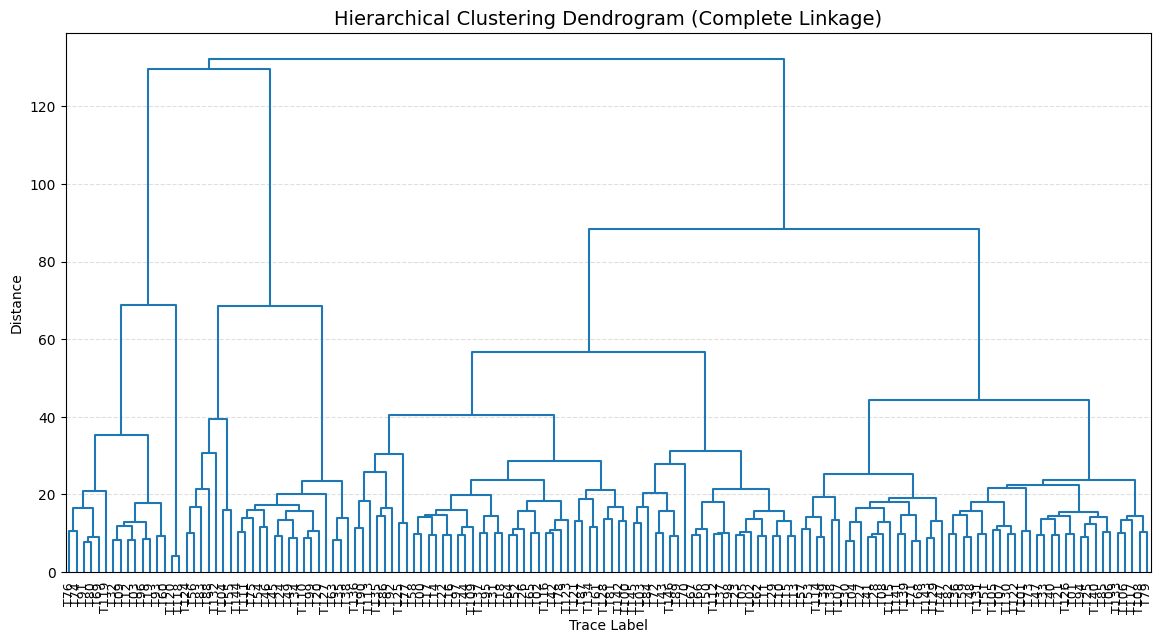


===== Cluster Composition =====

### Cluster 0
 T04 : start → SI → SI → SI → SI → SI → SI → SL → end
 T08 : start → SI → SI → SI → SI → SL → SI → SI → end
 T20 : start → SI → SI → SL → SI → SL → SI → SI → SL → end
 T24 : start → SI → SL → SL → SI → SI → SI → SI → SI → end
 T27 : start → SI → SI → SI → SI → SI → SI → SI → end
 T28 : start → SI → SI → SI → SI → SL → SL → SI → end
 T30 : start → SI → SI → SI → SI → SI → SL → SL → end
 T34 : start → SI → SI → SL → SI → SI → SL → SI → SI → end
 T35 : start → SI → SI → SI → SI → SI → SL → SI → SL → end
 T38 : start → SI → SI → SI → SI → SI → SI → SI → SI → end
 T39 : start → SI → SI → SI → SL → SI → SL → SI → end
 T41 : start → SI → SI → SI → SI → SI → SL → SI → end
 T45 : start → SI → SI → SL → SL → SI → SI → SI → SI → end
 T46 : start → SI → SL → SI → SI → SL → SI → SL → SI → end
 T49 : start → SI → SI → SL → SL → SI → SL → SI → SI → end
 T53 : start → SI → SI → SL → SI → SI → SI → SL → end
 T54 : start → SI → SL → SI → SI → SI → SI → SL 

In [ ]:
# Dendrogram 확인 후, 적절한 n_clusters 정의 후, sequences 확인
Dendrogram(final_results)

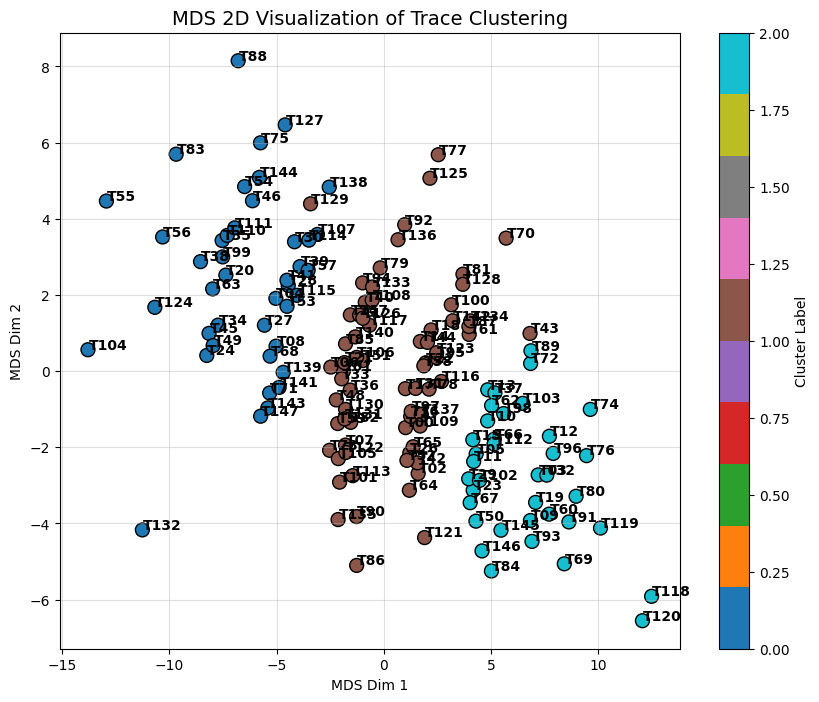

In [16]:
MDS(final_results)